In [1]:
#importing all neccessary packages 
import scipy.stats as sts
import heapq
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self, now = 0):
        self.now = now  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        #self.print_events()
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')


In [3]:
#implementation without extensions


class busstops:
    
    '''
    This class represents the bus stops. Its attributes store several variabels associated with bus stops such as 
    the number of people waiting. The method handle the arrival of people and people getting into a bus.
    '''
    
    def __init__(self, number, arrival_rate_function, schedule, length_function, travel_function):
        
        #number of the bus stop 
        self.number = number
        #number of people waiting
        self.waiting = 0
        #maximum number of people waiting in current simulation at this stop
        self.max_waiting = 0
        #list of arrival times of all poeple currently waiting 
        self.arrival = []
        #waiting times for all passengers who left the stop during the simulation
        self.waiting_times = []
        #arrival rate function for bus stop
        self.arrival_rate_function = arrival_rate_function
        #function that defines how many stations people want to travel
        self.length_function = length_function
        #function defining how long a bus takes from this stop to the next one. 
        self.travel_function = travel_function
        
        
    def add_traveler(self, schedule):
        '''
        This method adds a traveler to the stop and schedules the arrival of the next person
        '''
        #increase number of people waiting 
        self.waiting += 1
        #store new max length if neccessary
        if self.waiting > self.max_waiting:
            self.max_waiting = self.waiting
        #store arrival time 
        self.arrival.append(schedule.now)
        #schedule next arrival according to arrival function
        schedule.add_event_after(self.arrival_rate_function.rvs(), self.add_traveler)
        
    def bus_interaction(self, schedule,bus, wait):
        '''
        This method organizes people getting into the bus. It is able to repeat itself to account for people arriving while
        other poeple are getting into the bus.
        '''
        
        #count the number of people getting on the bus
        count = 0
        
        #print(f'interaction: bus {bus.number} at stop {self.number}. {self.waiting} people waiting.')
        
        #if there is space and the queue is not empty the next person is getting on the bus
        while wait < 4 and bus.people < bus.capacity and self.waiting> 0:
            #calculate waiting time and store it
            self.waiting_times.append(schedule.now - self.arrival[0])
            self.arrival.remove(self.arrival[0])
            #update people waiting and people in bus. 
            bus.people += 1
            self.waiting -= 1
            #stores the final destination of person 
            bus.embarking[(self.length_function.rvs()+self.number)% len(bus.stops)] += 1
            
            #increase count
            count += 1
        #keep track of how often the fuction gets repeated   
        wait += 1  
        
        #calculate and store the new filling of the bus
        bus.filling.append(bus.people/bus.capacity)
        
        #repeat function if at least 1 person got on the bus and we have waited less then 3 time. 
        if wait < 3 and count > 0:
            schedule.add_event_after(bus.embark_function(count).rvs(), self.bus_interaction, bus, wait +1)
        #otherwise schedule the arrival of the bus at the next stop
        else:
            schedule.add_event_after(self.travel_function.rvs(), bus.arrival)
            
        #print(f'{count} people getting in bus')
            
            
 
            
        


class bus:
    '''
    This class represents busses. Its attributes store several variabels associated with busses such as 
    the number of people in the bus. The method handles the arrival of the bus at a new stop.
    '''
    
    def __init__(self, number, capacity, location, stops, embark_function, disembark_function):
        
        #number of the bus 
        self.number = number
        #dictionary mapping each stop to the number of people in the bus that want to embark there 
        self.embarking = {}
        #number of people on bus
        self.people = 0
        #list of utilization of the bus throught simulation
        self.filling = [0]
        #max capacity of the bus
        self.capacity = capacity
        #current location of the bus
        self.location = location
        #list of all stops that the bus drives to
        self.stops = stops
        #function to calculate how long it takes to embark the bus
        self.embark_function = embark_function
        #functon to calculate how long it takes to disembark the bus
        self.disembark_function = disembark_function
        
        #set up dictionary according to the number of stops 
        for i in range(len(self.stops)):
            self.embarking[i] = 0
            
            
    def arrival(self, schedule):
        '''
        This method handels the arrival of a bus at a station and people disembarking there. 
        '''
        
        #increase location by 1
        self.location += 1
        #if we are at the last locaton circle back to the first 
        if self.location > len(self.stops)-1:
            self.location = 0
        
        #update number of people disembarking and dictionary accordingly 
        self.people -= self.embarking[self.location]
        embark = self.embarking[self.location]
        self.embarking[self.location] = 0
            
        #schedule poeple getting into the bus after the disembarking time
        if embark > 0:
            schedule.add_event_after(self.disembark_function(embark).rvs(), self.stops[self.location].bus_interaction,self, 0)
        else:
            schedule.add_event_after(0, self.stops[self.location].bus_interaction,self, 0)
            
        #print(f'arrival: bus {self.number} at stop {self.location}. {embark} people embarking. {self.people} in bus')
        
        
        
    


class system:
    '''
    This class creates all busses and stops and runs the simulation. 
    '''
    
    def __init__(self, num_stops, num_busses,initial_locations):
        #stores number of bus stops and busses 
        self.num_stops = num_stops
        self.num_busses = num_busses 
        #list of all bus stops
        self.stops = []
        #list of all busses 
        self.busses = []
        #creates and stores schedule
        self.schedule = Schedule()
        #initial location of busses
        self.initial_locations = initial_locations
        
        
    def set_up(self,arrival_rate_function, length_function, capacity, travel_function, embark_function, disembark_function):
        '''
        This method sets up all bus stops and busses with the approrite functions and parameters.
        '''
        
        #creating all bus stops 
        for i in range(self.num_stops):
            self.stops.append(busstops(i, arrival_rate_function, self.schedule, length_function, travel_function))
        #creating all busses
        for i in range(self.num_busses):
            self.busses.append(bus(i, capacity, self.initial_locations[i], self.stops, embark_function, disembark_function))
    
    def run_simulation(self,run_until):
        '''
        This method initiates and runs the simulation
        '''
        
        #initiating arrival of people at all stops 
        for i in self.stops:
            self.schedule.add_event_after(i.arrival_rate_function.rvs(), i.add_traveler)
        #initiates all busses driving 
        for i in self.busses:
            self.schedule.add_event_after(self.stops[i.location].travel_function.rvs(), i.arrival)
        
        #triggers next event until end time is reached
        while self.schedule.next_event_time() <= run_until:
            self.schedule.run_next_event()
            
    
    def get_stats(self):
        '''
        This method combines several staitsics from all bus stops and busses
        '''
        
        #store empty lists
        all_waiting_times = []
        all_max = 0
        all_fillings = []
        pl = []
        
        #fill lists from bus stop info
        for st in self.stops:
            all_waiting_times = all_waiting_times + st.waiting_times
            
            if st.max_waiting > all_max:
                all_max = st.max_waiting
                
            pl.append(st.people_leaving)
        
        #fill list with bus info
        for bu in self.busses:
            all_fillings = all_fillings + bu.filling
            
        
        return [all_waiting_times, [all_max], all_fillings, pl]
    
    
    
    
def get_mean_with_confind(l):
    '''
    Function that takes list as input and returns list with mean and 95% confidence interval.
    '''
    confint = sts.t.interval(0.95, len(l)-1, loc=np.mean(l), scale=sts.sem(l))
    return [np.mean(l), confint[0], confint[1]]
        
        

In [4]:
#defining all neccessary functions 

# continues arrival function
af = sts.expon(scale = 1/1)

#time of day dependent arrival function
def a2f(t):
    r = 1.2 + math.cos(math.pi * ((t/60)-7) / 6)
    return sts.expon(scale = 1/r)

#max capacity of busses 
c = 130 

#function defining how many stops people want to stay on the bus 
lf = sts.randint(1,8)

#function defining how long busses travel
t2f = sts.truncnorm(a=-4, b=np.inf, loc=2, scale=0.5)

#disembarking function
def d2f(n):
    return sts.truncnorm(a = (0- (0.03*n))/ ( 0.01* math.sqrt(n)), b = np.inf, loc = 0.03*n, scale = 0.01* math.sqrt(n))

#embarking function
def e2f(n):
    return sts.truncnorm(a =  (0- (0.05*n))/ ( 0.01* math.sqrt(n)), b = np.inf, loc = 0.05*n, scale = 0.01* math.sqrt(n))

In [5]:
# run example simulation 

s = system( 15, 2,[0, 14])
s.set_up(af,lf, c, t2f, e2f, d2f)
s.run_simulation(800)

In [6]:
#implementation with extensions 

        



class busstops:
    '''
    This class represents the bus stops. Its attributes store several variabels associated with bus stops such as 
    the number of people waiting. The method handle the arrival of people and people getting into a bus.
    '''
    
    def __init__(self, number, arrival_rate_function, schedule, length_function, travel_function):
        
        #number of the bus stop
        self.number = number
        #number of people waiting
        self.waiting = 0
        #maximum number of people waiting in current simulation at this stop
        self.max_waiting = 0
        #list of arrival times of all poeple currently waiting
        self.arrival = []
        #waiting times for all passengers who left the stop during the simulation
        self.waiting_times = []
        #arrival rate function for bus stop
        self.arrival_rate_function = arrival_rate_function
        #function that defines how many stations people want to travel
        self.length_function = length_function
        #function defining how long a bus takes from this stop to the next one. 
        self.travel_function = travel_function
        #stores the number of people leaving the station
        self.people_leaving = 0
        
        
        
        
    def add_traveler(self, schedule):
        '''
        This method adds a traveler to the stop and schedules the arrival of the next person
        '''
        #increase number of people waiting
        self.waiting += 1
        #store new max length if neccessary
        if self.waiting > self.max_waiting:
            self.max_waiting = self.waiting
        #store arrival time
        self.arrival.append(schedule.now)
        #schedule next arrival according to arrival function
        schedule.add_event_after(self.arrival_rate_function(schedule.now).rvs(), self.add_traveler)
        #schedule to check if person leaves after 10 minutes
        schedule.add_event_after(10, self.remove_traveler, schedule.now)
    
                
            
    def remove_traveler(self, schedule, ar):
        '''
        This method checks if a person leaves after 10 minutes. A person leaves if he
        is still in the queue and there are at least 20 people in front of him
        '''        
        #initiate variable to store position of waiting person
        position = None 
        #find position of waiting person based on arrival time 
        for i in range(len(self.arrival)):
            if self.arrival[i] == ar:
                position = i
        #if person is still in line and at least 20 peopel are in front of him he leaves
        if position != None and (len(self.arrival)-1) - position >= 20:
            #update arrival, waiting and people elaving 
            self.arrival.remove(self.arrival[position])
            self.waiting -= 1
            self.people_leaving += 1

        
    def bus_interaction(self, schedule,bus, wait):
        '''
        This method organizes people getting into the bus. It is able to repeat itself to account for people arriving while
        other poeple are getting into the bus.
        '''
        #count the number of people getting on the bus
        count = 0
        
        #if there is space and the queue is not empty the next person is getting on the bus
        while wait < 4 and bus.people < bus.capacity and self.waiting> 0:
            #calculate waiting time and store it
            self.waiting_times.append(schedule.now - self.arrival[0])
            self.arrival.remove(self.arrival[0])
            #update people waiting and people in bus.
            bus.people += 1
            self.waiting -= 1
            #stores the final destination of person
            bus.embarking[(self.length_function.rvs()+self.number)% len(bus.stops)] += 1
            
            #increase count
            count += 1
        
        #keep track of how often the fuction gets repeated
        wait += 1  

        #calculate and store the new filling of the bus
        bus.filling.append(bus.people/bus.capacity)
        
        #repeat function if at least 1 person got on the bus and we have waited less then 3 time.
        if wait < 3 and count > 0:
            schedule.add_event_after(bus.embark_function(count).rvs(), self.bus_interaction, bus, wait +1)
        #otherwise schedule the arrival of the bus at the next stop
        else:
            schedule.add_event_after(self.travel_function.rvs(), bus.arrival)



class bus:
    '''
    This class represents busses. Its attributes store several variabels associated with busses such as 
    the number of people in the bus. The method handles the arrival of the bus at a new stop.
    '''
    def __init__(self, number, capacity, location, stops, embark_function, disembark_function):
        
        #number of the bus 
        self.number = number
        #dictionary mapping each stop to the number of people in the bus that want to embark there 
        self.embarking = {}
        #number of people on bus
        self.people = 0
        #list of utilization of the bus throught simulation
        self.filling = [0]
        #max capacity of the bus
        self.capacity = capacity
        #current location of the bus
        self.location = location
        #list of all stops that the bus drives to
        self.stops = stops
        #function to calculate how long it takes to embark the bus
        self.embark_function = embark_function
        #functon to calculate how long it takes to disembark the bus
        self.disembark_function = disembark_function
        
        #set up dictionary according to the number of stops 
        for i in range(len(self.stops)):
            self.embarking[i] = 0
            
            
    def arrival(self, schedule):
        '''
        This method handels the arrival of a bus at a station and people disembarking there. 
        '''
        
        #increase location by 1
        self.location += 1
        #if we are at the last locaton circle back to the first 
        if self.location > len(self.stops)-1:
            self.location = 0
        
        #update number of people disembarking and dictionary accordingly 
        self.people -= self.embarking[self.location]
        embark = self.embarking[self.location]
        self.embarking[self.location] = 0
        #schedule poeple getting into the bus after the disembarking time
        if embark > 0:
            schedule.add_event_after(self.disembark_function(embark).rvs(), self.stops[self.location].bus_interaction,self, 0)
        else:
            schedule.add_event_after(0, self.stops[self.location].bus_interaction,self, 0)

            
            
            
            
class system:
    '''
    This class creates all busses and stops and runs the simulation. 
    '''
    
    def __init__(self, num_stops, num_busses,initial_locations, start = 0):
        
        #stores number of bus stops and busses
        self.num_stops = num_stops
        self.num_busses = num_busses 
        #list of all bus stops
        self.stops = []
        #list of all busses 
        self.busses = []
        #creates and stores schedule
        self.schedule = Schedule(start)
        #initial location of busses
        self.initial_locations = initial_locations
        
        
    def set_up(self,arrival_rate_function, length_function, capacity, travel_function, embark_function, disembark_function):
        '''
        This method sets up all bus stops and busses with the approrite functions and parameters.
        '''
        
        #creating all bus stops
        for i in range(self.num_stops):
            self.stops.append(busstops(i, arrival_rate_function, self.schedule, length_function, travel_function))
        #creating all busses
        for i in range(self.num_busses):
            self.busses.append(bus(i, capacity, self.initial_locations[i], self.stops, embark_function, disembark_function))
    
    def run_simulation(self,run_until):
        '''
        This method initiates and runs the simulation
        '''
        
        #initiating arrival of people at all stops
        for i in self.stops:
            self.schedule.add_event_after(i.arrival_rate_function(self.schedule.now).rvs(), i.add_traveler)
        #initiates all busses driving 
        for i in self.busses:
            self.schedule.add_event_after(self.stops[i.location].travel_function.rvs(), i.arrival)
        #triggers next event until end time is reached
        while self.schedule.next_event_time() <= run_until:
            self.schedule.run_next_event()
            
    
    
    def get_stats(self):
        '''
        This method combines several staitsics from all bus stops and busses
        '''
        
        #store empty lists
        all_waiting_times = []
        all_max = 0
        all_fillings = []
        pl = []
        
        #fill lists from bus stop info
        for st in self.stops:
            all_waiting_times = all_waiting_times + st.waiting_times
            
            if st.max_waiting > all_max:
                all_max = st.max_waiting
                
            pl.append(st.people_leaving)
        
        #fill list with bus info
        for bu in self.busses:
            all_fillings = all_fillings + bu.filling
            
        
        return [all_waiting_times, [all_max], all_fillings, pl]

        
        

In [7]:
#list of initial bus stops 
buspos = [0, 7, 12, 3, 10, 14, 5, 9, 13, 2, 11, 1, 6,8, 4]

#setting up litst to store results 
waiting = []
max_l = []
bus_fil = []
people_leave = []

allm = [waiting, max_l, bus_fil, people_leave]
results = [[],[],[],[]]

#run for 1 to 15 busses 
for i in range(1, 16):
    for u in allm:
        u.append([])
        #repeat 10 times 
    for u in range(10):
        #set up simulation
        s = system( 15, i,buspos[:i])
        s.set_up(a2f,lf, c, t2f, e2f, d2f)
        #run for one day
        s.run_simulation(1440)
        #get and store statistics
        stats = s.get_stats()
        for y in range(len(allm)):
            allm[y][-1] += stats[y]
            
    #store means and confidence intervals        
    for u in range(len(allm)):
        results[u].append(get_mean_with_confind(allm[u][-1]))
            
    
    
    

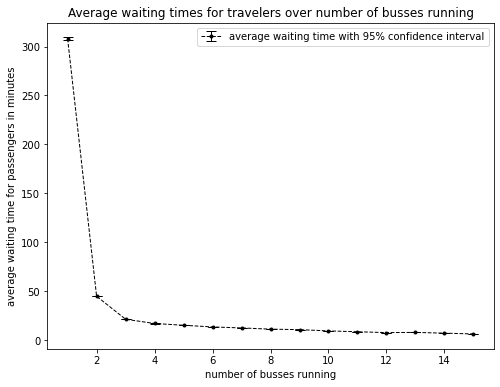

In [8]:
#create plots 


plt.figure(figsize=(8, 6))
plt.title('Average waiting times for travelers over number of busses running')
plt.xlabel('number of busses running')
plt.ylabel('average waiting time for passengers in minutes')
plt.errorbar(
    [i for i in range(1, 16)],  [i[0] for i in results[0]],  [[i[0] - i[1][0] for i in results[0]], [i[2][0]-i[0] for i in results[0]]],
    color='black', marker='.', capsize=5, linestyle='--', linewidth=1,
    label='average waiting time with 95% confidence interval') 

plt.legend()
plt.show()

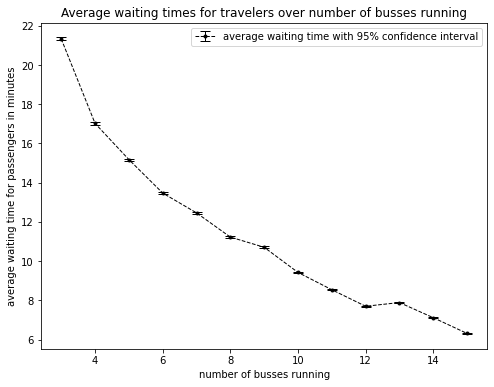

In [9]:
plt.figure(figsize=(8, 6))
plt.title('Average waiting times for travelers over number of busses running')
plt.xlabel('number of busses running')
plt.ylabel('average waiting time for passengers in minutes')
plt.errorbar(
    [i for i in range(1, 16)][2:],  [i[0] for i in results[0]][2:],  [[i[0] - i[1][0] for i in results[0]][2:], [i[2][0]-i[0] for i in results[0]][2:]],
    color='black', marker='.', capsize=5, linestyle='--', linewidth=1,
    label='average waiting time with 95% confidence interval') 

plt.legend()
plt.show()

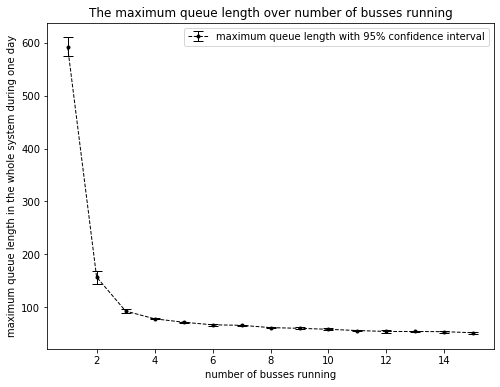

In [10]:



plt.figure(figsize=(8, 6))

plt.title('The maximum queue length over number of busses running')
plt.xlabel('number of busses running')
plt.ylabel('maximum queue length in the whole system during one day')
plt.errorbar(
    [i for i in range(1, 16)],  [i[0] for i in results[1]],  [[i[0] - i[1] for i in results[1]], [i[2]-i[0] for i in results[1]]],
    color='black', marker='.', capsize=5, linestyle='--', linewidth=1,
    label='maximum queue length with 95% confidence interval') 

plt.legend()
plt.show()

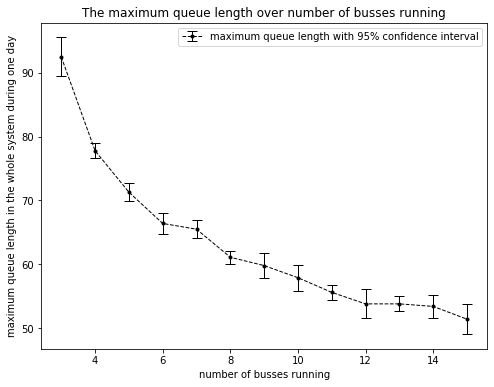

In [11]:
plt.figure(figsize=(8, 6))

plt.title('The maximum queue length over number of busses running')
plt.xlabel('number of busses running')
plt.ylabel('maximum queue length in the whole system during one day')

plt.errorbar(
    [i for i in range(1, 16)][2:],  [i[0] for i in results[1]][2:],  [[i[0] - i[1] for i in results[1]][2:], [i[2]-i[0] for i in results[1]][2:]],
    color='black', marker='.', capsize=5, linestyle='--', linewidth=1,
    label='maximum queue length with 95% confidence interval') 

plt.legend()
plt.show()

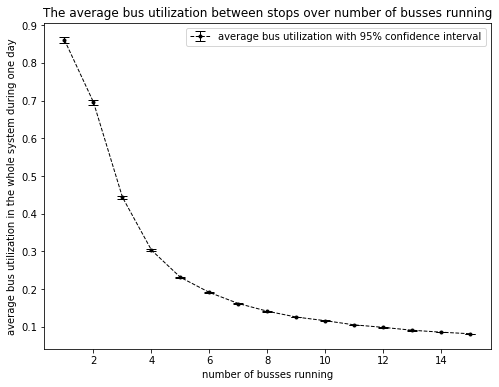

In [12]:


plt.figure(figsize=(8, 6))

plt.title('The average bus utilization between stops over number of busses running')
plt.xlabel('number of busses running')
plt.ylabel('average bus utilization in the whole system during one day')

plt.errorbar(
    [i for i in range(1, 16)],  [i[0] for i in results[2]],  [[i[0] - i[1] for i in results[2]], [i[2]-i[0] for i in results[2]]],
    color='black', marker='.', capsize=5, linestyle='--', linewidth=1,
    label='average bus utilization with 95% confidence interval') 


plt.legend()
plt.show()

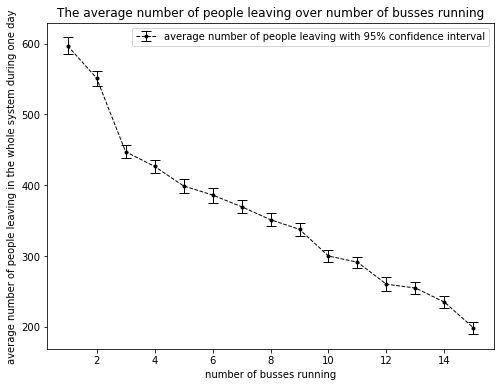

In [14]:



plt.figure(figsize=(8, 6))

plt.title('The average number of people leaving over number of busses running')
plt.xlabel('number of busses running')
plt.ylabel('average number of people leaving in the whole system during one day')
plt.errorbar(
    [i for i in range(1, 16)],  [i[0] for i in results[3]],  [[i[0] - i[1] for i in results[3]], [i[2]-i[0] for i in results[3]]],
    color='black', marker='.', capsize=5, linestyle='--', linewidth=1,
    label='average number of people leaving with 95% confidence interval') 


plt.legend()
plt.show()

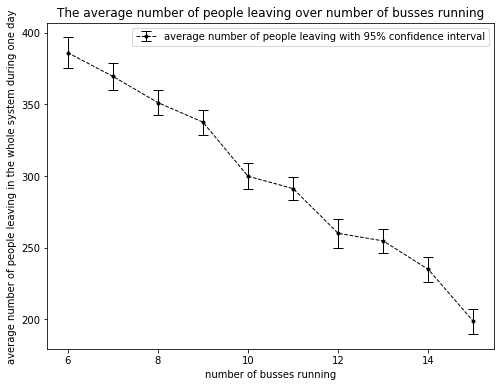

In [15]:
plt.figure(figsize=(8, 6))

plt.title('The average number of people leaving over number of busses running')
plt.xlabel('number of busses running')
plt.ylabel('average number of people leaving in the whole system during one day')

plt.errorbar(
    [i for i in range(1, 16)][5:],  [i[0] for i in results[3]][5:],  [[i[0] - i[1] for i in results[3]][5:], [i[2]-i[0] for i in results[3]][5:]],
    color='black', marker='.', capsize=5, linestyle='--', linewidth=1,
    label='average number of people leaving with 95% confidence interval') 

plt.legend()
plt.show()

In [16]:
#initial bus positions
buspos = [0, 7, 12, 3, 10, 14, 5, 9, 13, 2, 11, 1, 6,8, 4]

#create lists to store results 
waiting3 = []
max_l3 = []
bus_fil3 = []
people_leave3 = []

#start and beginning time 
times3 = 0
timeu3 = 60


allm3 = [waiting3, max_l3, bus_fil3, people_leave3]
results3 = []

#run simulation for each hour of the day
for z in range(24):
    results3.append([[],[],[],[]])
    #run simulation for 5 to 9 busses 
    for i in range(5, 10):
        for u in allm3:
            u.append([])
        #repeat each simulation 5 times 
        for u in range(5):
            s = system( 15, i,buspos[:i], times3)
            s.set_up(a2f,lf, c, t2f, e2f, d2f)
            s.run_simulation(timeu3)
            stats = s.get_stats()
            for y in range(len(allm3)):
                allm3[y][-1] += stats[y]



        for u in range(len(allm3)):
            results3[-1][u].append(get_mean_with_confind(allm3[u][-1]))

    times3 +=60
    timeu3 += 60

C:\Users\Joram Erbarth\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\Joram Erbarth\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


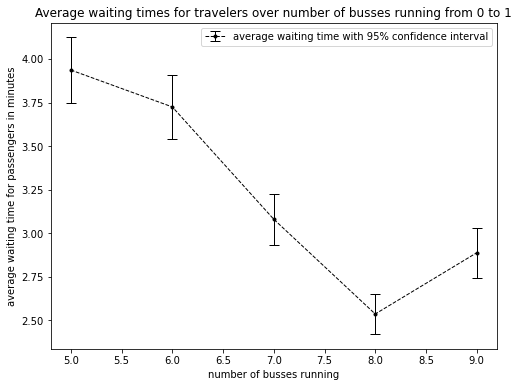

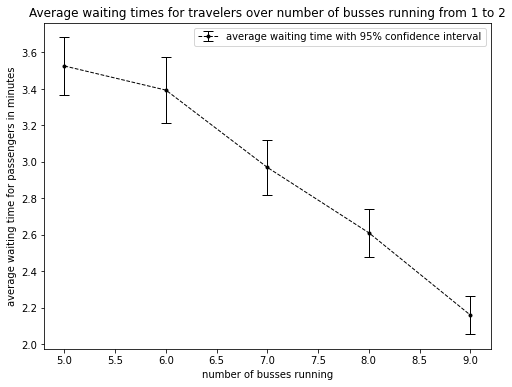

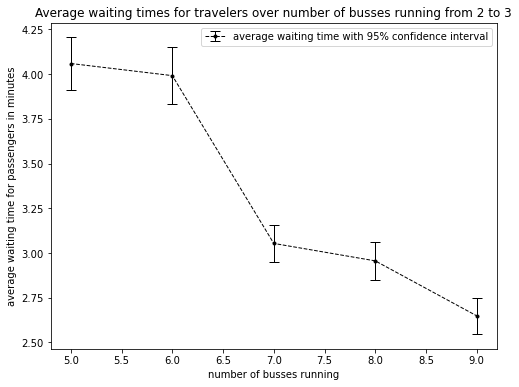

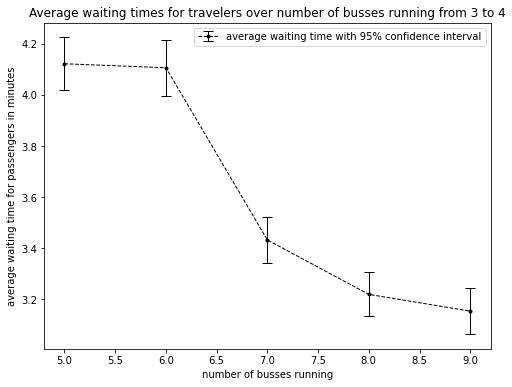

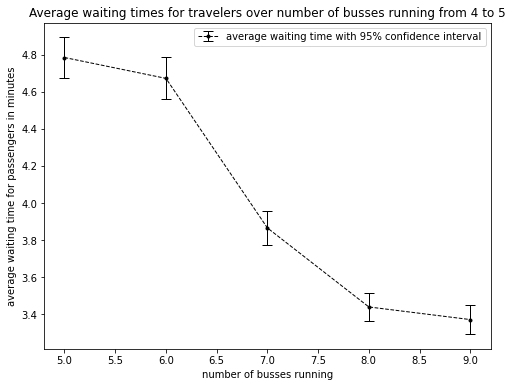

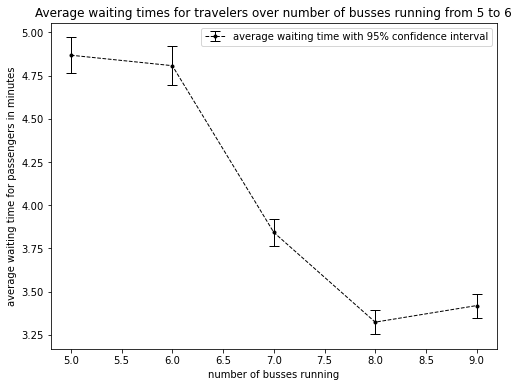

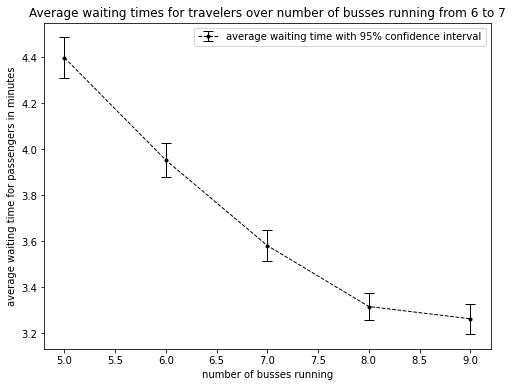

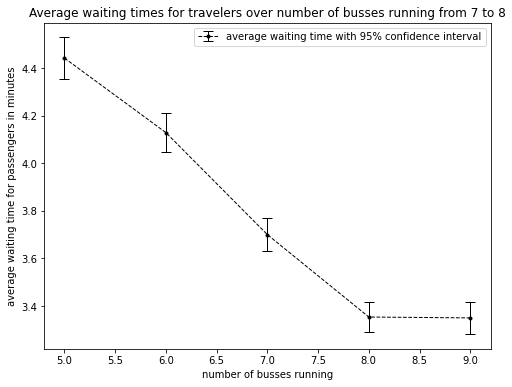

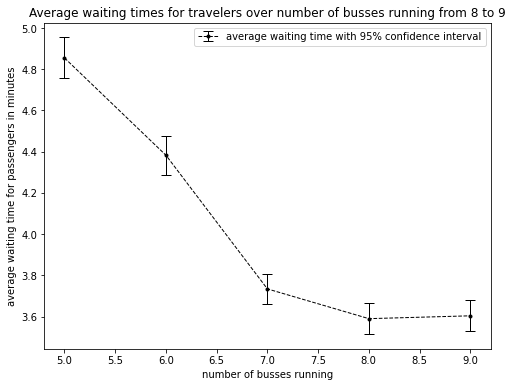

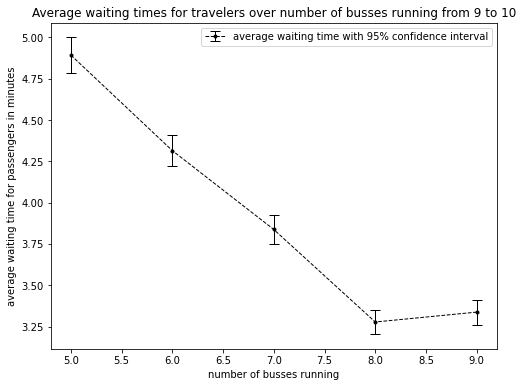

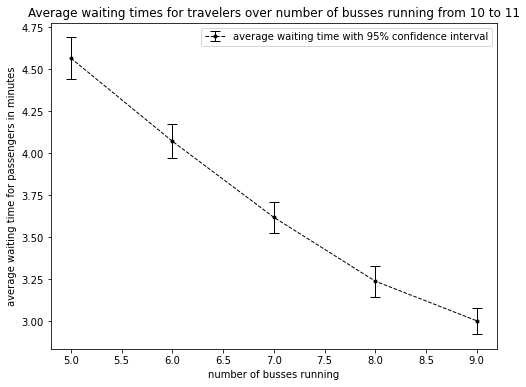

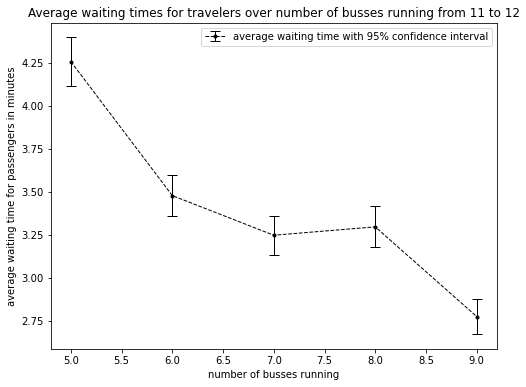

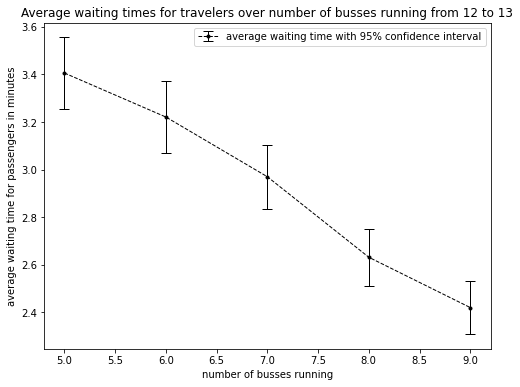

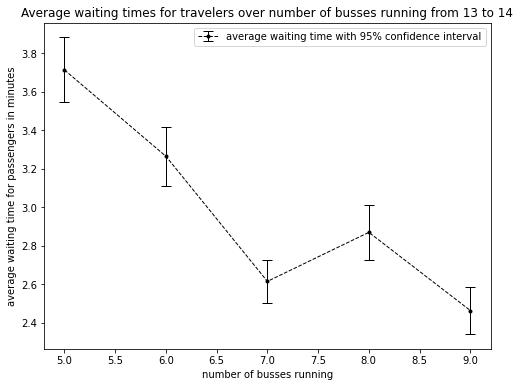

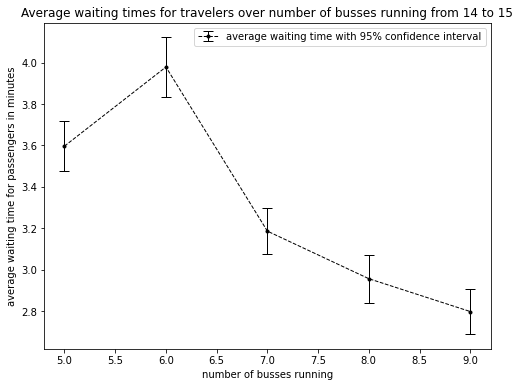

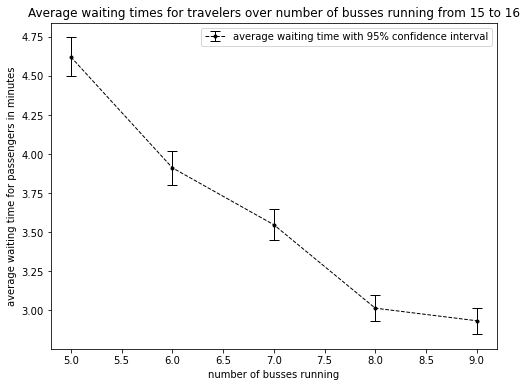

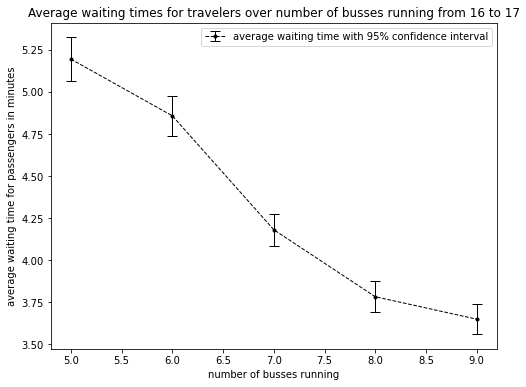

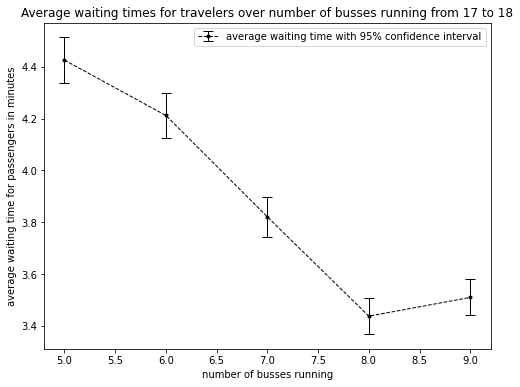

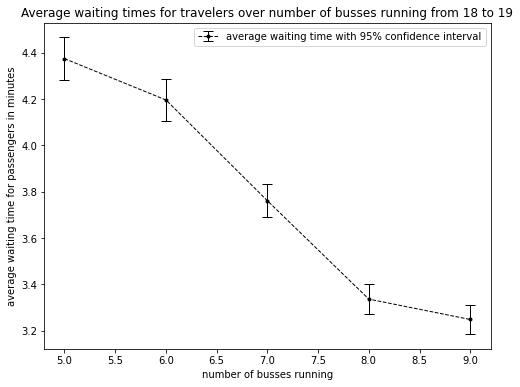

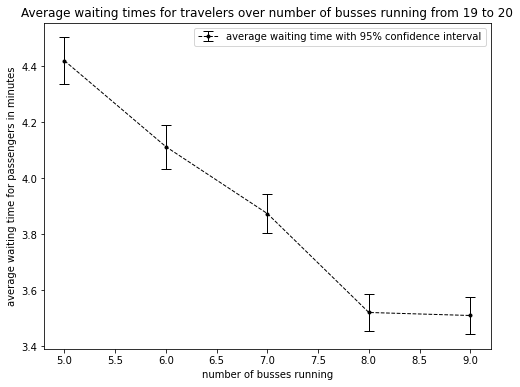

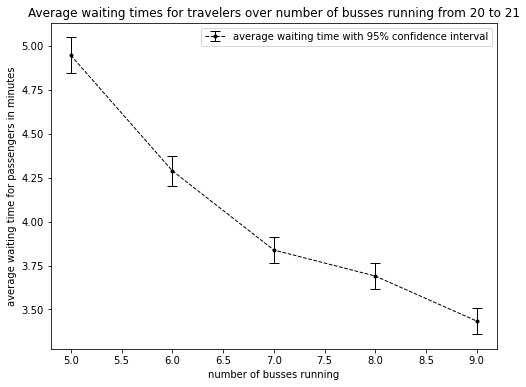

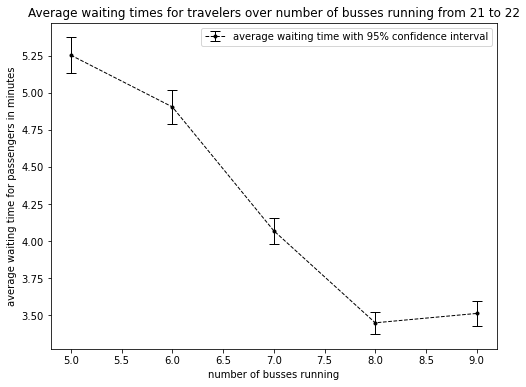

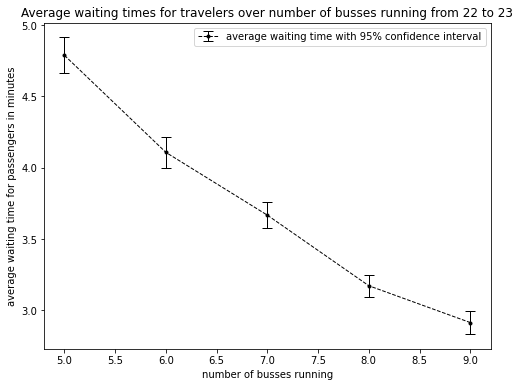

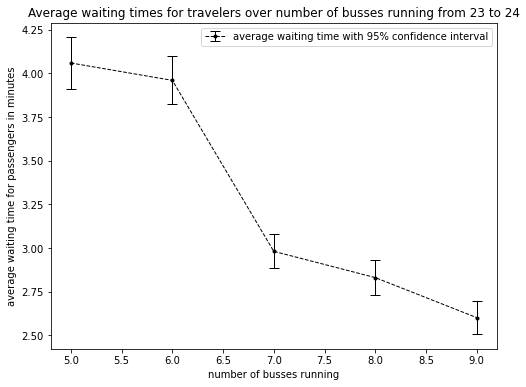

In [17]:
#make figures 


for i in range(24):
    plt.figure(figsize=(8, 6))
    plt.title(f'Average waiting times for travelers over number of busses running from {0+i} to {1+i}')
    plt.xlabel('number of busses running')
    plt.ylabel('average waiting time for passengers in minutes')

    plt.errorbar(
        [i for i in range(5, 10)],  [i[0] for i in results3[i][0]],  [[i[0] - i[1][0] for i in results3[i][0]], [i[2][0]-i[0] for i in results3[i][0]]],
        color='black', marker='.', capsize=5, linestyle='--', linewidth=1,
        label='average waiting time with 95% confidence interval') 
    
    plt.legend()
    plt.show()

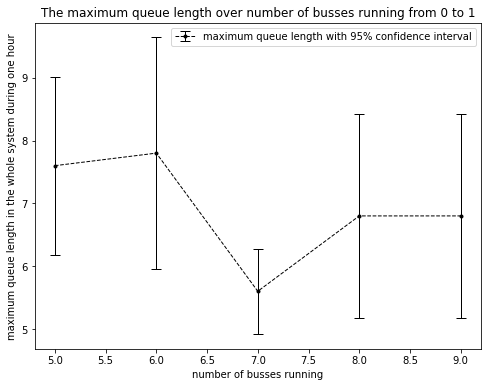

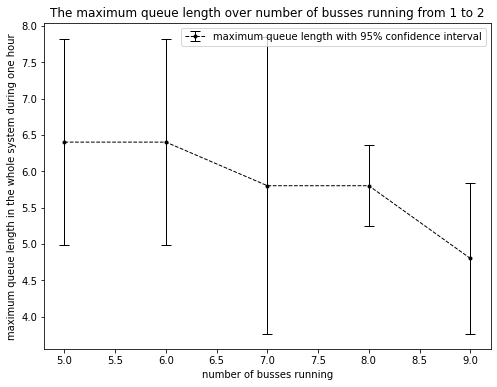

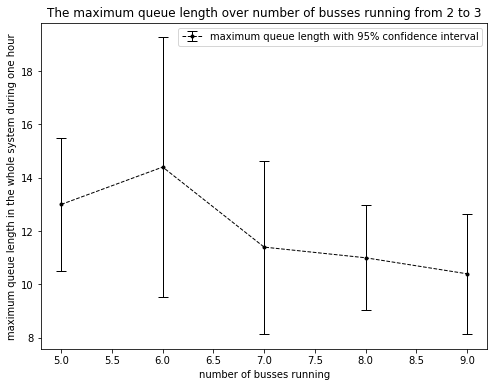

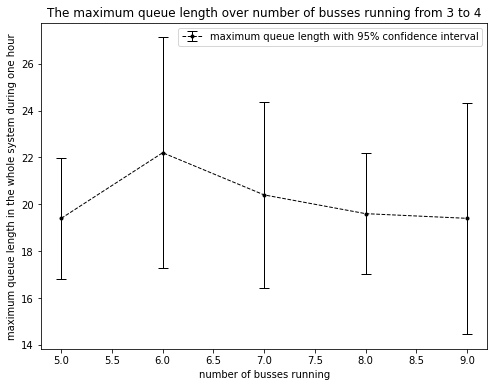

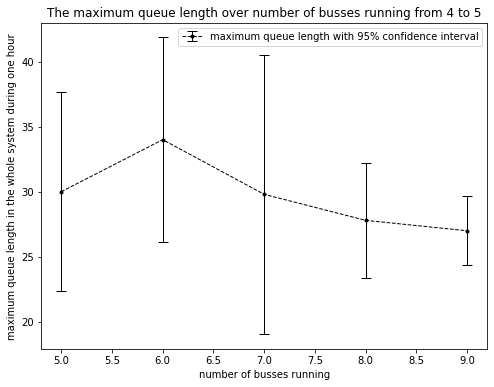

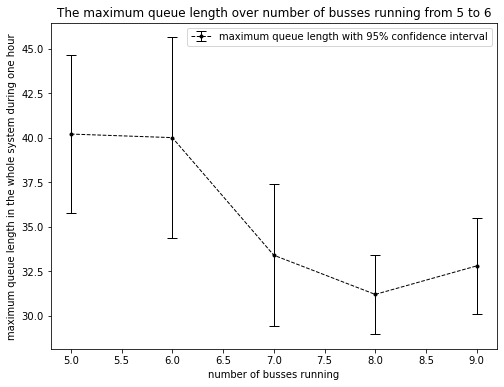

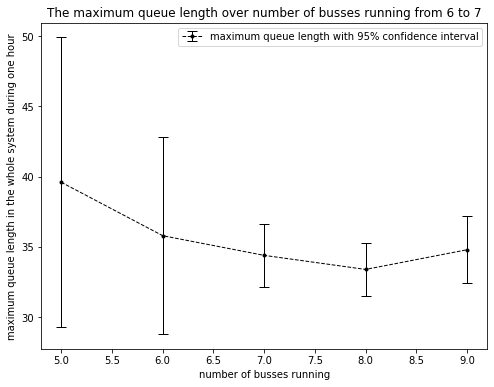

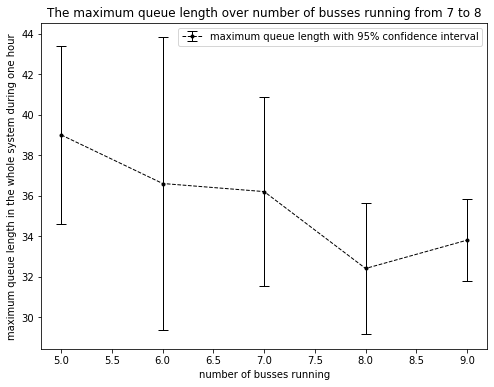

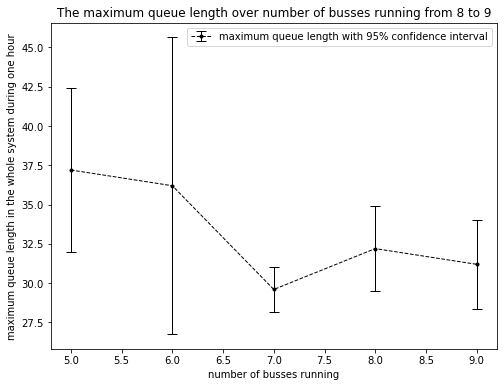

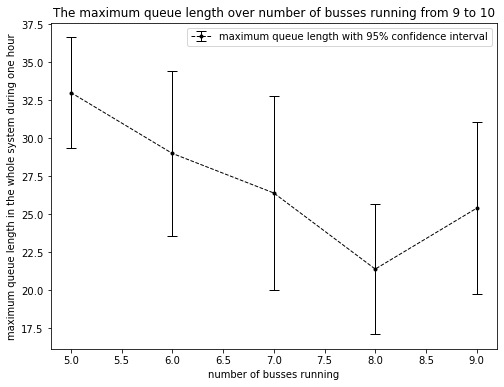

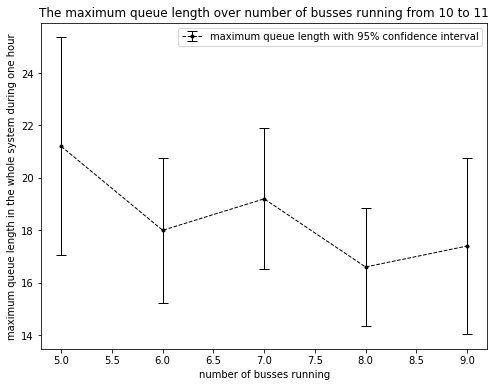

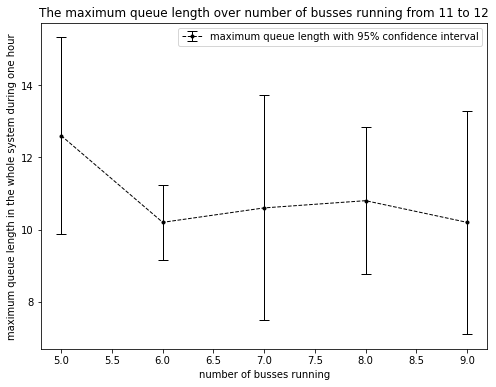

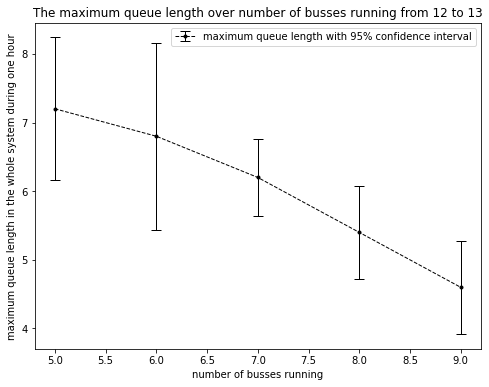

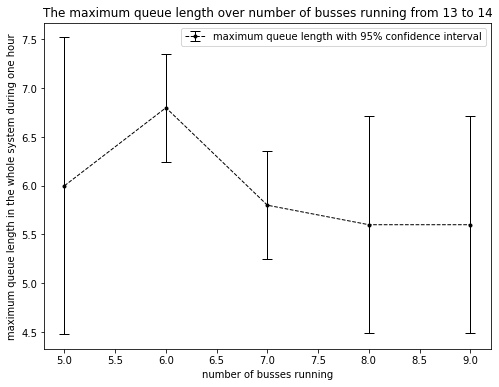

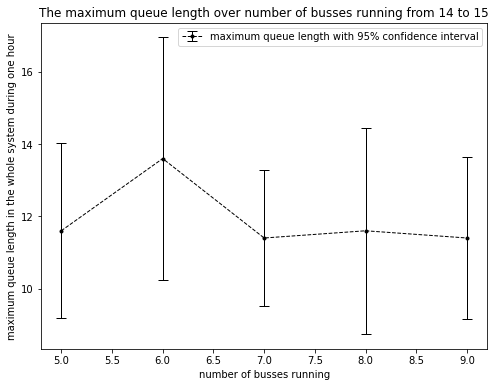

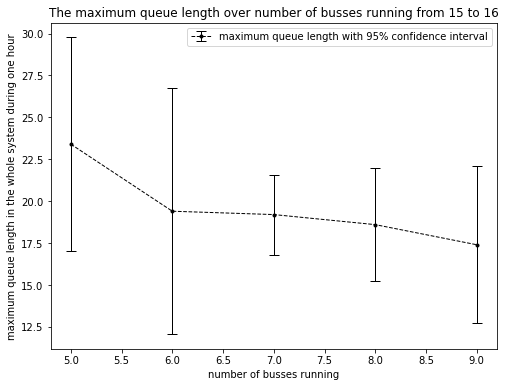

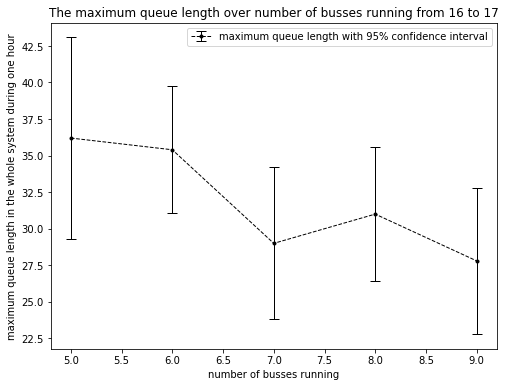

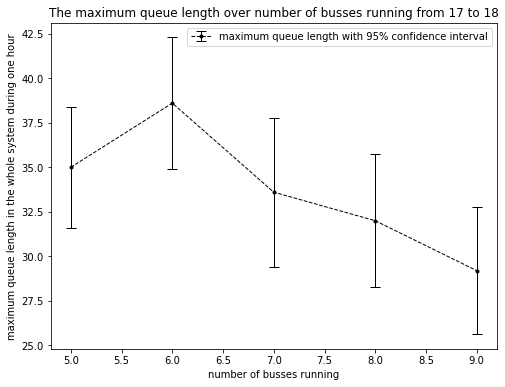

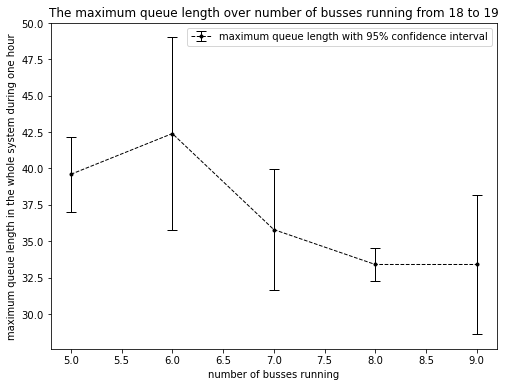

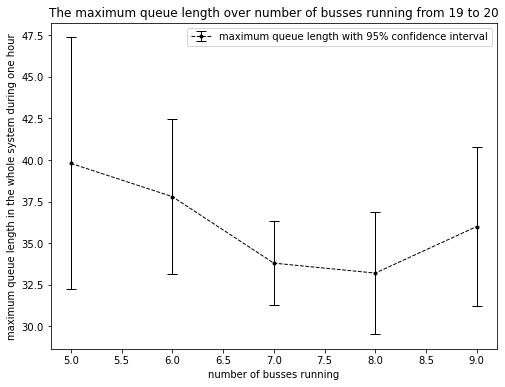

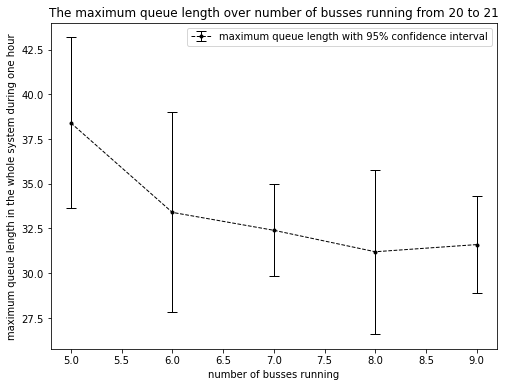

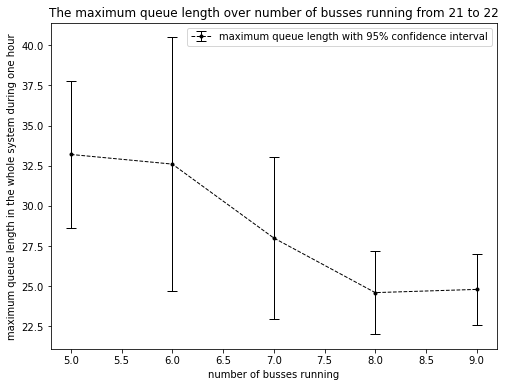

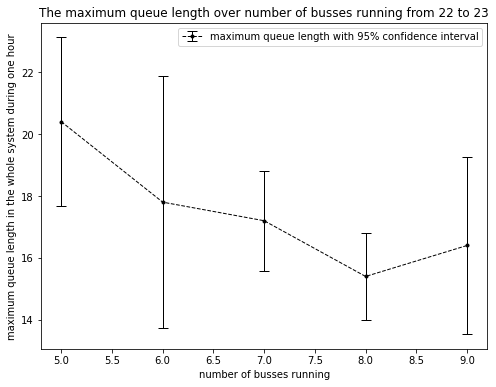

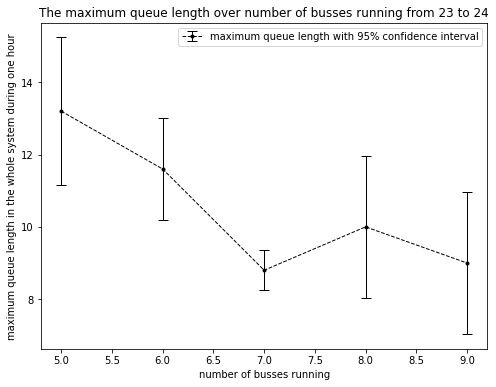

In [18]:
for i in range(24):
    plt.figure(figsize=(8, 6))

    plt.title(f'The maximum queue length over number of busses running from {0+i} to {1+i}')
    plt.xlabel('number of busses running')
    plt.ylabel('maximum queue length in the whole system during one hour')

    
    plt.errorbar(
        [i for i in range(5, 10)],  [i[0] for i in results3[i][1]],  [[i[0] - i[1] for i in results3[i][1]], [i[2]-i[0] for i in results3[i][1]]],
        color='black', marker='.', capsize=5, linestyle='--', linewidth=1,
        label='maximum queue length with 95% confidence interval') 
    
    plt.legend()
    plt.show()

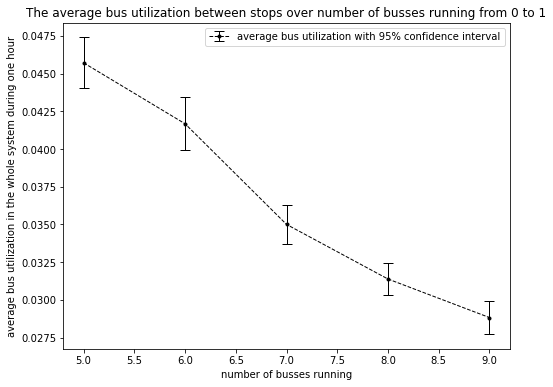

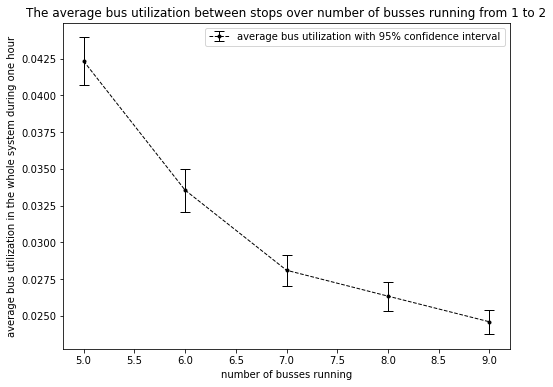

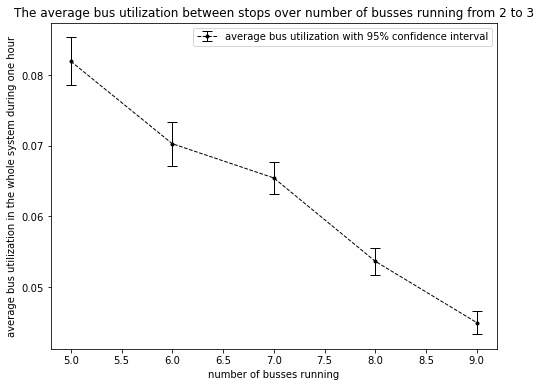

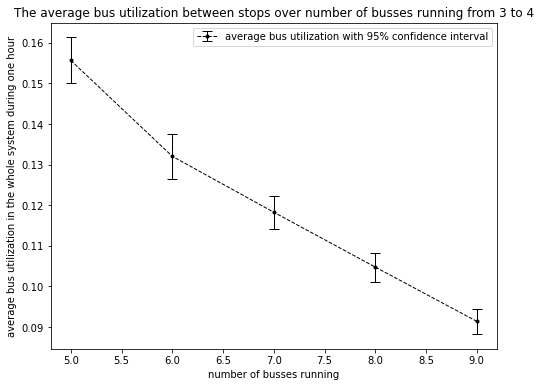

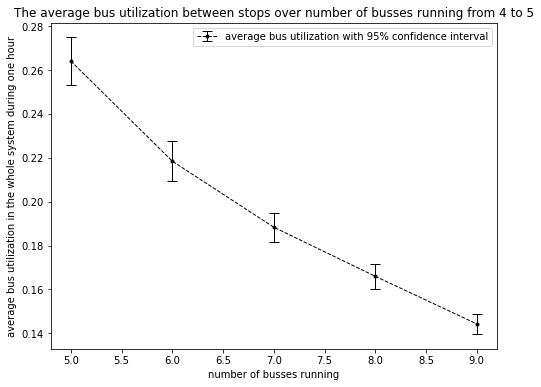

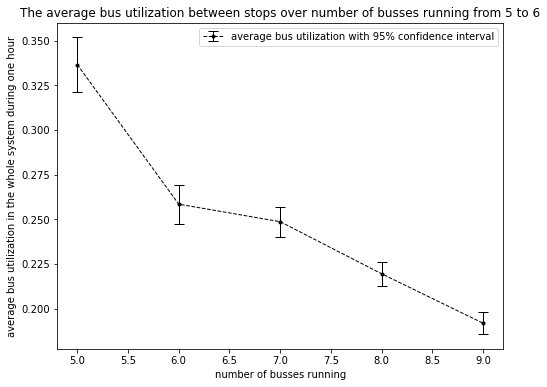

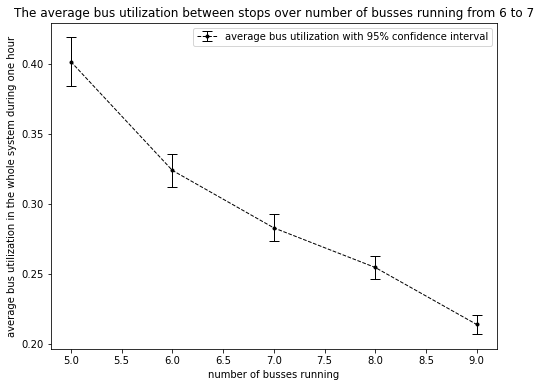

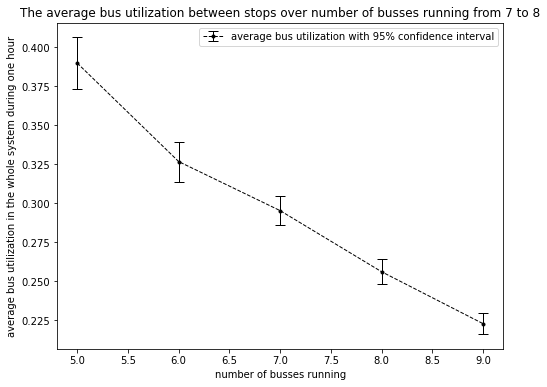

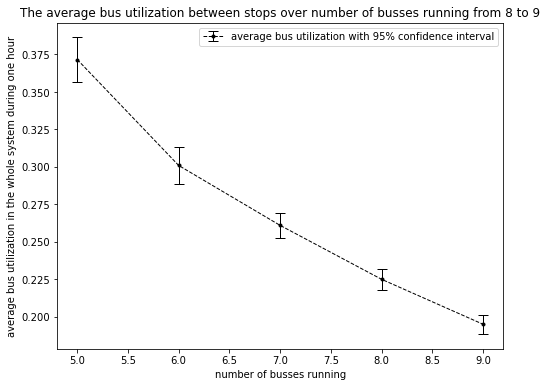

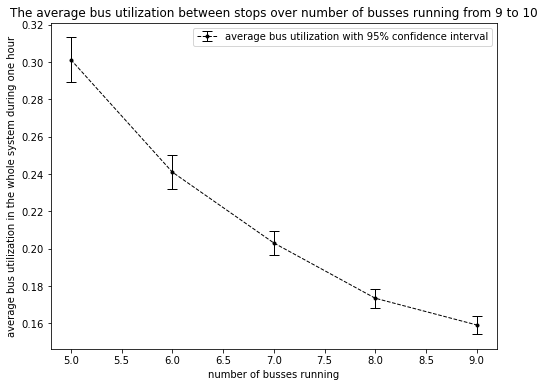

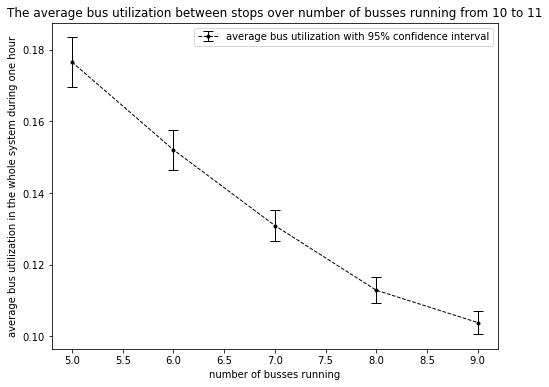

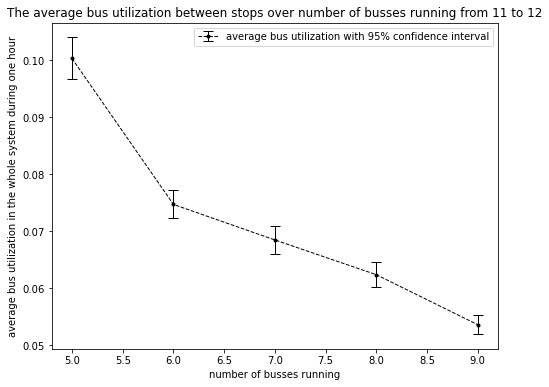

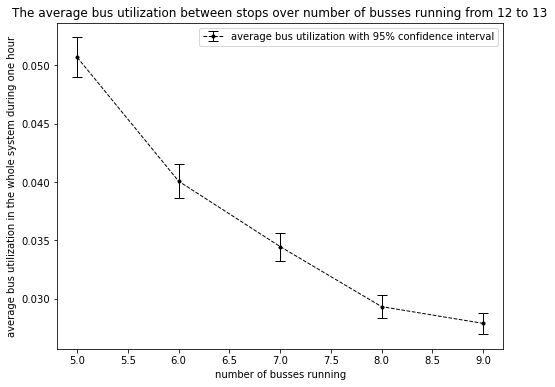

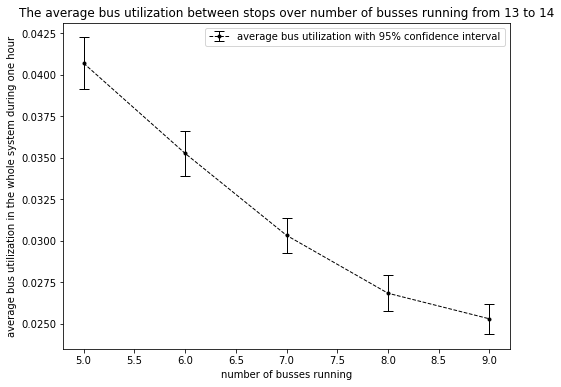

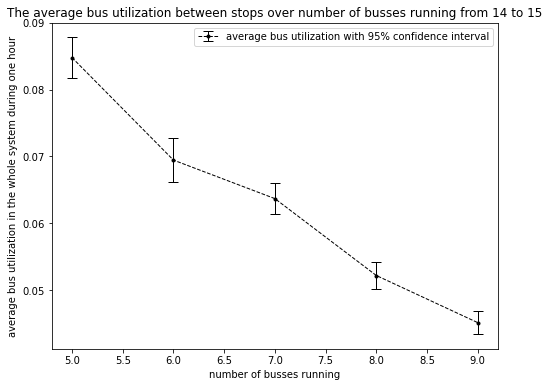

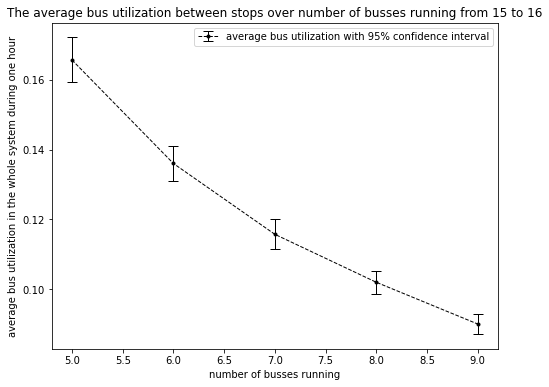

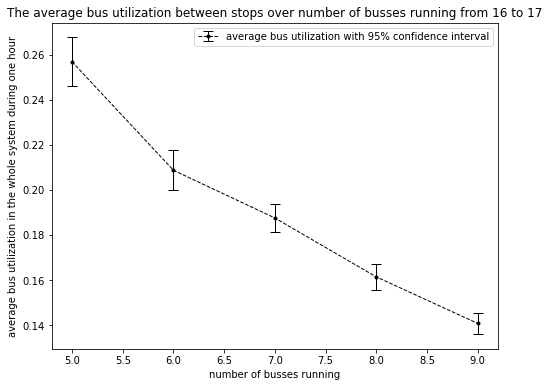

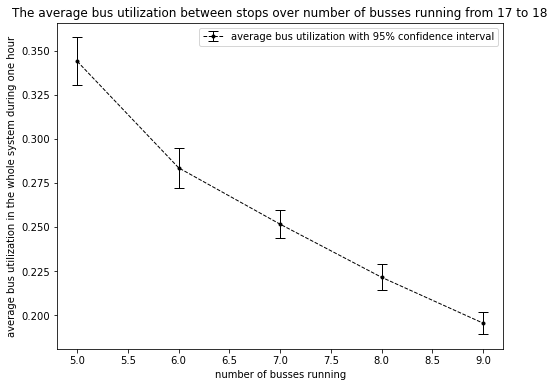

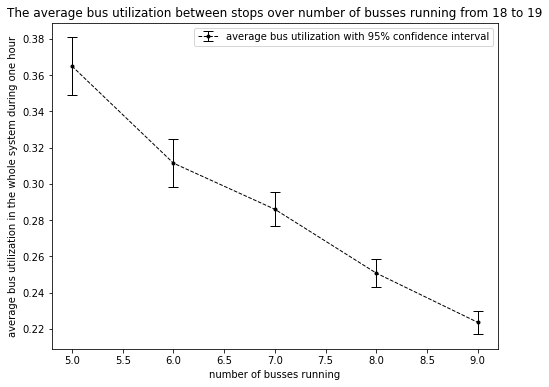

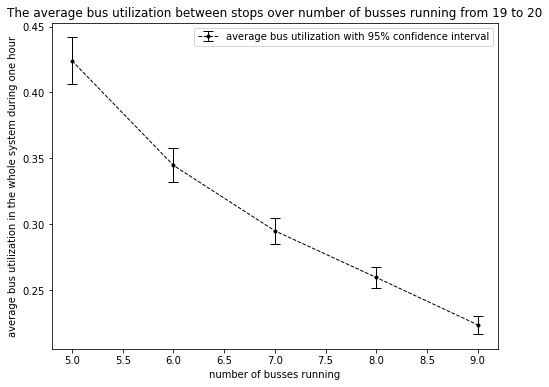

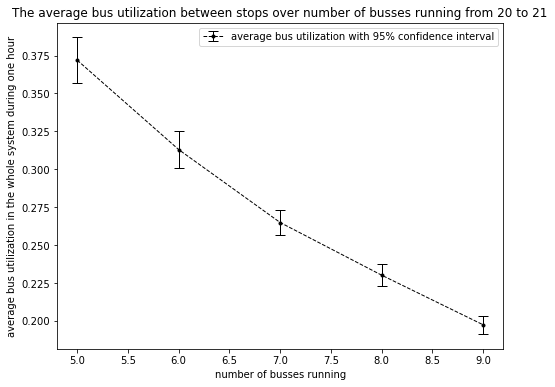

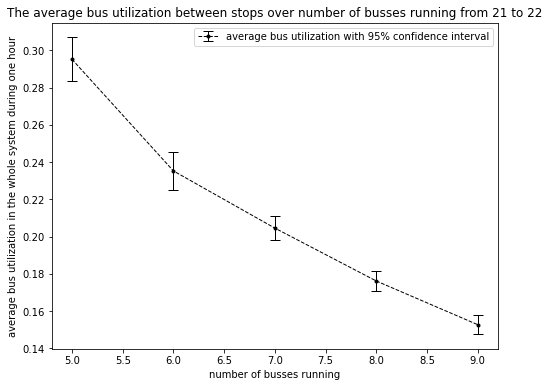

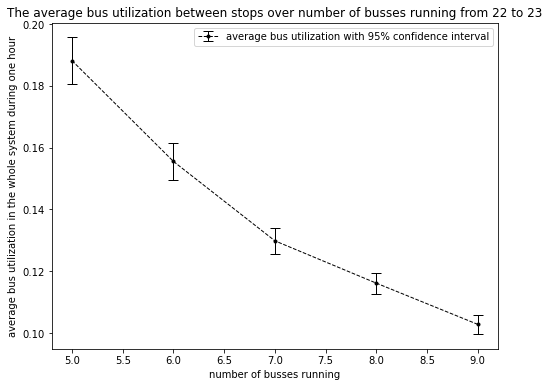

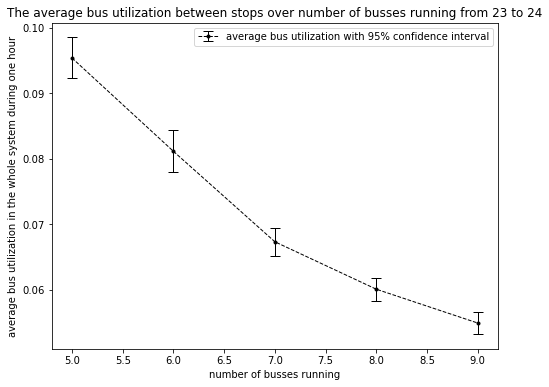

In [19]:
for i in range(24):
    plt.figure(figsize=(8, 6))

    plt.title(f'The average bus utilization between stops over number of busses running from {0+i} to {1+i}')
    plt.xlabel('number of busses running')
    plt.ylabel('average bus utilization in the whole system during one hour')

    plt.errorbar(
        [i for i in range(5, 10)],  [i[0] for i in results3[i][2]],  [[i[0] - i[1] for i in results3[i][2]], [i[2]-i[0] for i in results3[i][2]]],
        color='black', marker='.', capsize=5, linestyle='--', linewidth=1,
        label='average bus utilization with 95% confidence interval') 
    
    plt.legend()
    plt.show()
    

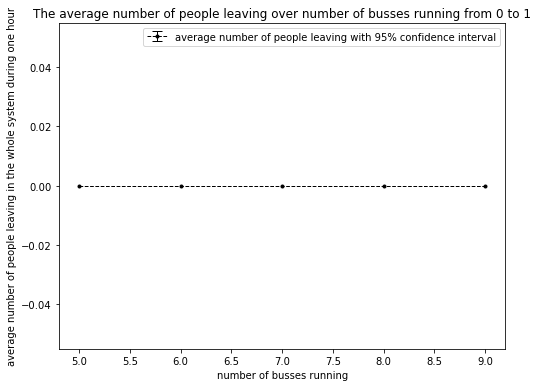

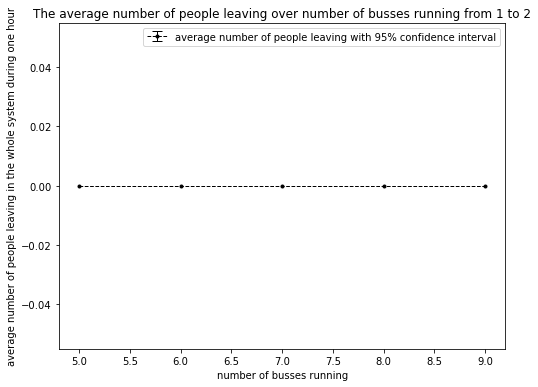

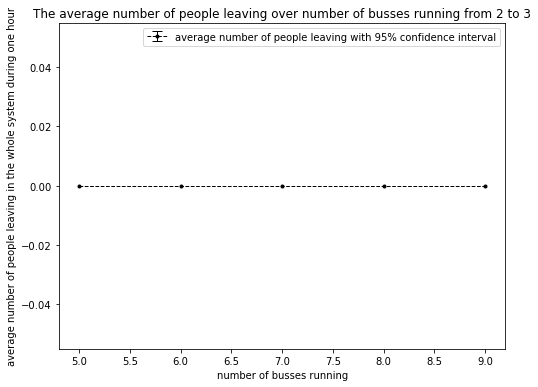

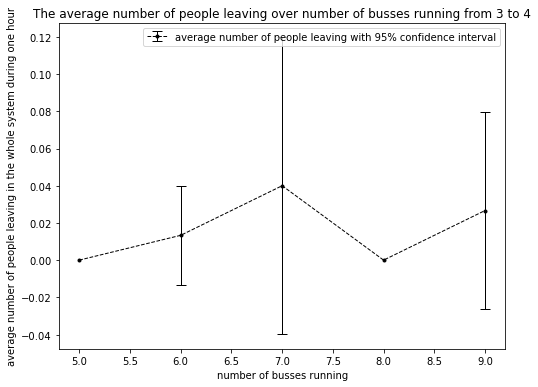

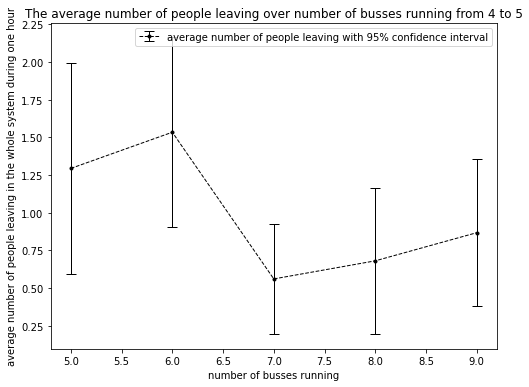

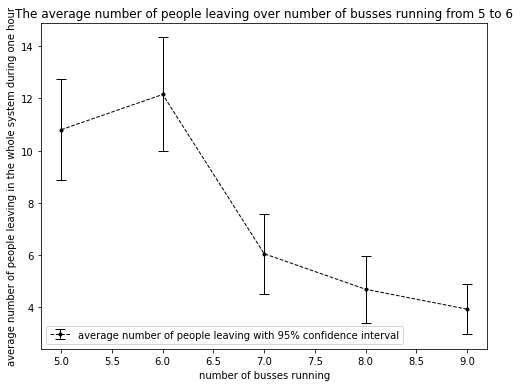

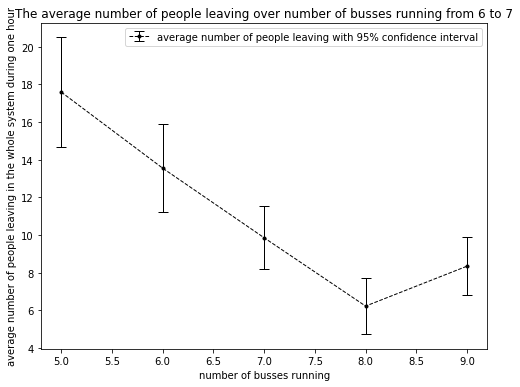

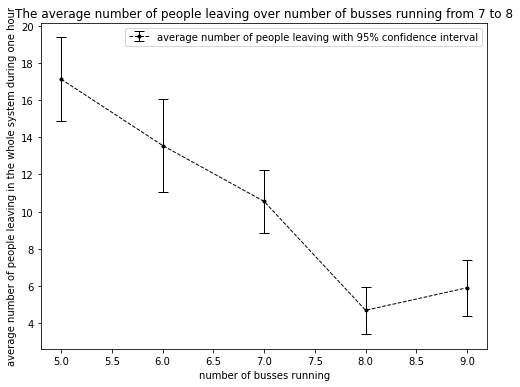

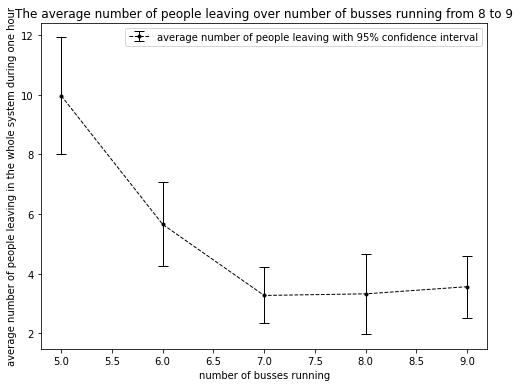

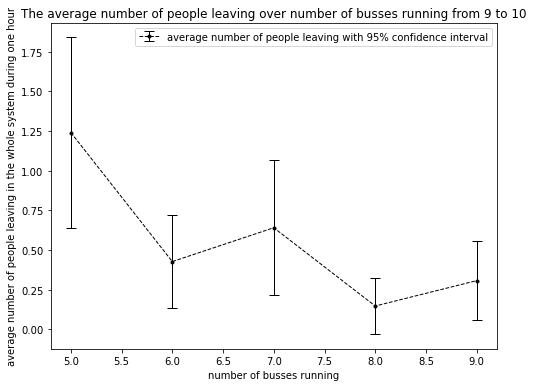

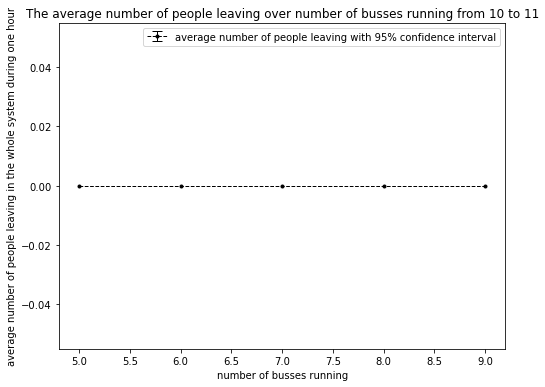

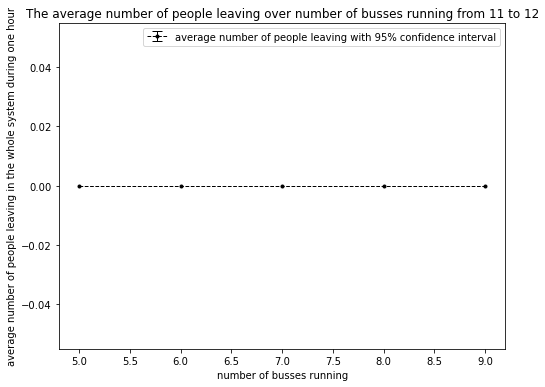

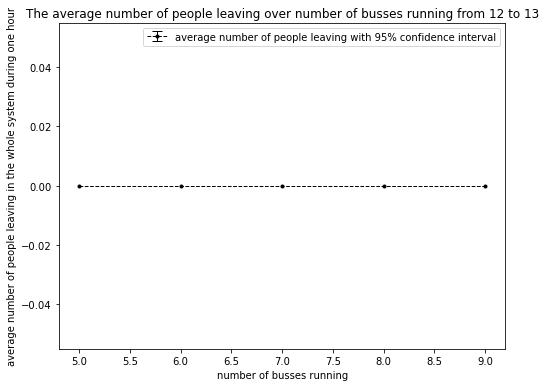

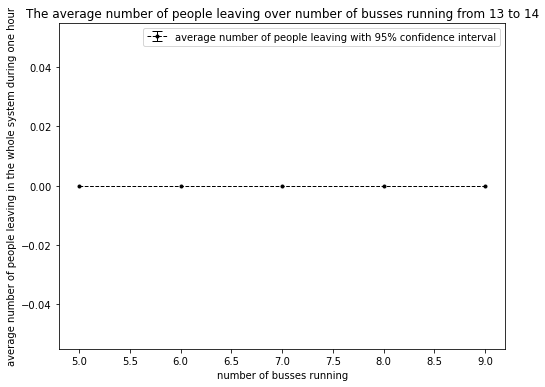

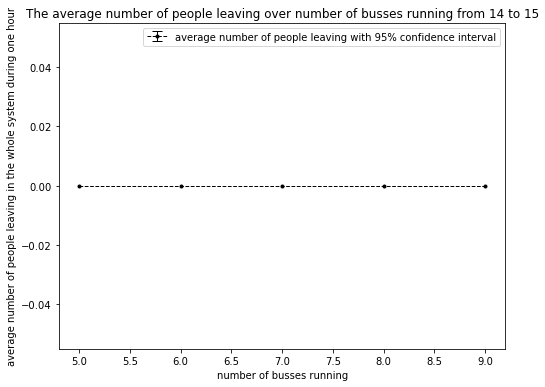

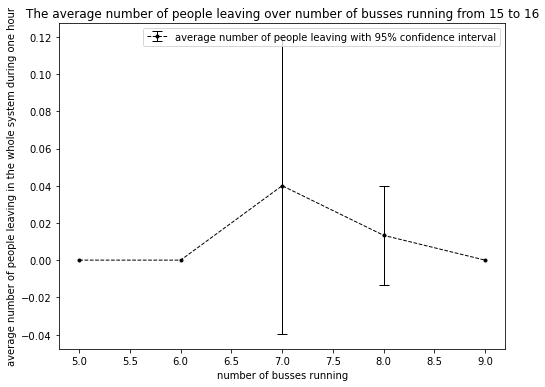

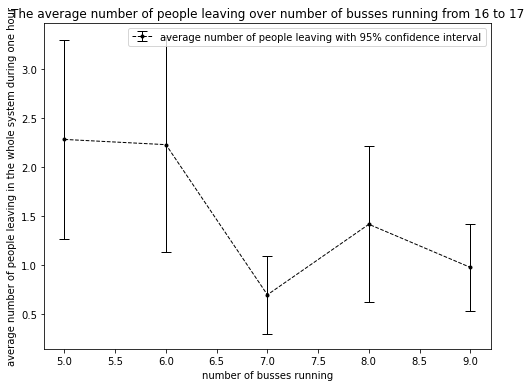

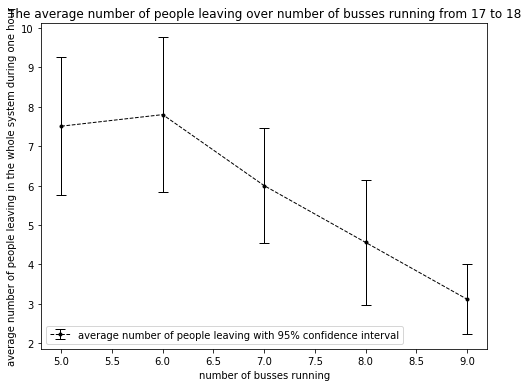

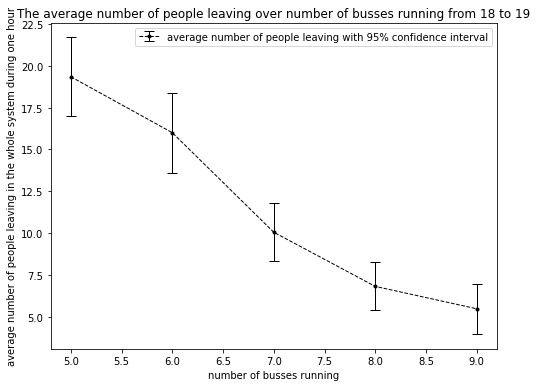

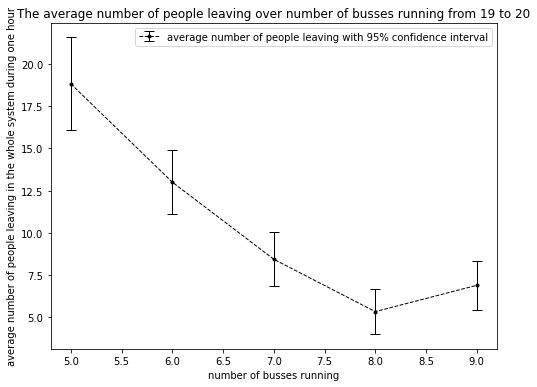

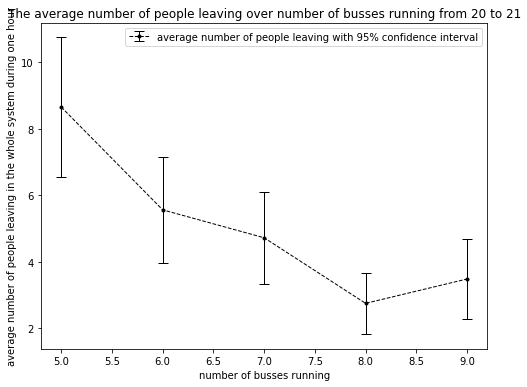

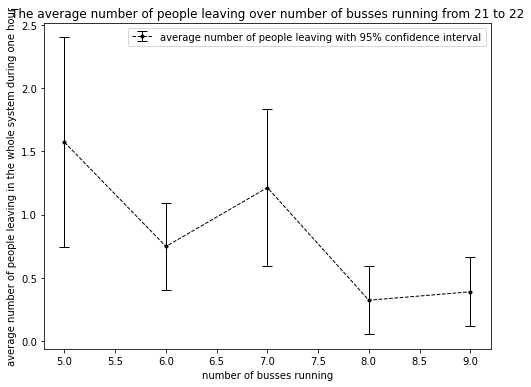

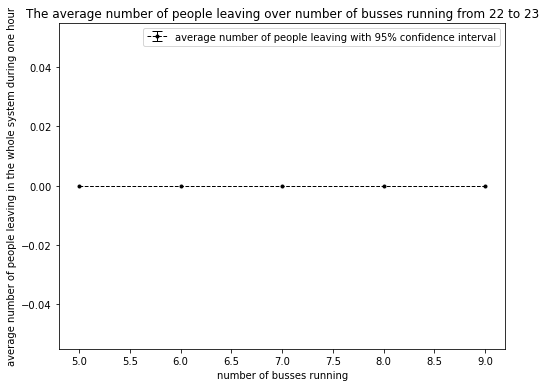

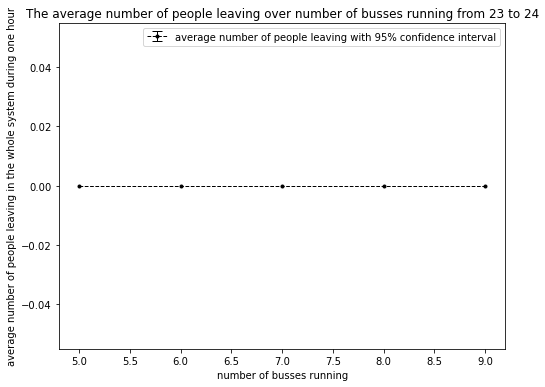

In [20]:
for i in range(24):
    plt.figure(figsize=(8, 6))

    plt.title(f'The average number of people leaving over number of busses running from {0+i} to {1+i}')
    plt.xlabel('number of busses running')
    plt.ylabel('average number of people leaving in the whole system during one hour')

    plt.errorbar(
        [i for i in range(5, 10)],  [i[0] for i in results3[i][3]],  [[i[0] - i[1] for i in results3[i][3]], [i[2]-i[0] for i in results3[i][3]]],
        color='black', marker='.', capsize=5, linestyle='--', linewidth=1,
        label='average number of people leaving with 95% confidence interval') 
    
    plt.legend()
    plt.show()

In [21]:
#implementation with extensions 

        



class busstops:
    '''
    This class represents the bus stops. Its attributes store several variabels associated with bus stops such as 
    the number of people waiting. The method handle the arrival of people and people getting into a bus.
    '''
    
    def __init__(self, number, arrival_rate_function, schedule, length_function, travel_function):
        
        #number of the bus stop
        self.number = number
        #number of people waiting
        self.waiting = 0
        #maximum number of people waiting in current simulation at this stop
        self.max_waiting = 0
        #list of arrival times of all poeple currently waiting
        self.arrival = []
        #waiting times for all passengers who left the stop during the simulation
        self.waiting_times = []
        #arrival rate function for bus stop
        self.arrival_rate_function = arrival_rate_function
        #function that defines how many stations people want to travel
        self.length_function = length_function
        #function defining how long a bus takes from this stop to the next one. 
        self.travel_function = travel_function
        #stores the number of people leaving the station
        self.people_leaving = 0
        
        
        
        
    def add_traveler(self, schedule, busses):
        '''
        This method adds a traveler to the stop and schedules the arrival of the next person
        '''
        #increase number of people waiting
        self.waiting += 1
        #store new max length if neccessary
        if self.waiting > self.max_waiting:
            self.max_waiting = self.waiting
        #store arrival time
        self.arrival.append(schedule.now)
        #schedule next arrival according to arrival function
        schedule.add_event_after(self.arrival_rate_function(schedule.now).rvs(), self.add_traveler)
        #schedule to check if person leaves after 10 minutes
        #schedule.add_event_after(10, self.remove_traveler, schedule.now)
        schedule.add_event_after(1, self.remove_traveler_new, busses)
    
    def remove_traveler_new(self, schedule, busses):
        '''
        Checks if the person is faster waiting for the bus or walking and makes a decision accordingly 
        '''
        
        #store distance to next bus
        min_dist = np.inf
        
        #find next bus and distance 
        for i in busses:
            dist = self.number - i
            if dist < 0:
                dist = (len(busses) - i) + self.number
                
            if dist < min_dist:
                min_dist = dist
        
        #calculate walking and driving times 
        numbst = self.length_function.rvs()
        bt = 3*(min_dist+numbst)
        wt = 15 * numbst
        
        #leave the station if the walking is faster then taking the bus
        if wt < bt:
            self.arrival.remove(self.arrival[position])
            self.waiting -= 1
            self.people_leaving += 1
    
                
            
    def remove_traveler(self, schedule, ar):
        '''
        This method checks if a person leaves after 10 minutes. A person leaves if he
        is still in the queue and there are at least 20 people in front of him
        '''        
        #initiate variable to store position of waiting person
        position = None 
        #find position of waiting person based on arrival time 
        for i in range(len(self.arrival)):
            if self.arrival[i] == ar:
                position = i
        #if person is still in line and at least 20 peopel are in front of him he leaves
        if position != None and (len(self.arrival)-1) - position >= 20:
            #update arrival, waiting and people elaving 
            self.arrival.remove(self.arrival[position])
            self.waiting -= 1
            self.people_leaving += 1

        
    def bus_interaction(self, schedule,bus, wait):
        '''
        This method organizes people getting into the bus. It is able to repeat itself to account for people arriving while
        other poeple are getting into the bus.
        '''
        #count the number of people getting on the bus
        count = 0
        
        #if there is space and the queue is not empty the next person is getting on the bus
        while wait < 4 and bus.people < bus.capacity and self.waiting> 0:
            #calculate waiting time and store it
            self.waiting_times.append(schedule.now - self.arrival[0])
            self.arrival.remove(self.arrival[0])
            #update people waiting and people in bus.
            bus.people += 1
            self.waiting -= 1
            #stores the final destination of person
            bus.embarking[(self.length_function.rvs()+self.number)% len(bus.stops)] += 1
            
            #increase count
            count += 1
        
        #keep track of how often the fuction gets repeated
        wait += 1  

        #calculate and store the new filling of the bus
        bus.filling.append(bus.people/bus.capacity)
        
        #repeat function if at least 1 person got on the bus and we have waited less then 3 time.
        if wait < 3 and count > 0:
            schedule.add_event_after(bus.embark_function(count).rvs(), self.bus_interaction, bus, wait +1)
        #otherwise schedule the arrival of the bus at the next stop
        else:
            schedule.add_event_after(self.travel_function.rvs(), bus.arrival)



class bus:
    '''
    This class represents busses. Its attributes store several variabels associated with busses such as 
    the number of people in the bus. The method handles the arrival of the bus at a new stop.
    '''
    def __init__(self, number, capacity, location, stops, embark_function, disembark_function):
        
        #number of the bus 
        self.number = number
        #dictionary mapping each stop to the number of people in the bus that want to embark there 
        self.embarking = {}
        #number of people on bus
        self.people = 0
        #list of utilization of the bus throught simulation
        self.filling = [0]
        #max capacity of the bus
        self.capacity = capacity
        #current location of the bus
        self.location = location
        #list of all stops that the bus drives to
        self.stops = stops
        #function to calculate how long it takes to embark the bus
        self.embark_function = embark_function
        #functon to calculate how long it takes to disembark the bus
        self.disembark_function = disembark_function
        
        #set up dictionary according to the number of stops 
        for i in range(len(self.stops)):
            self.embarking[i] = 0
            
            
    def arrival(self, schedule):
        '''
        This method handels the arrival of a bus at a station and people disembarking there. 
        '''
        
        #increase location by 1
        self.location += 1
        #if we are at the last locaton circle back to the first 
        if self.location > len(self.stops)-1:
            self.location = 0
        
        #update number of people disembarking and dictionary accordingly 
        self.people -= self.embarking[self.location]
        embark = self.embarking[self.location]
        self.embarking[self.location] = 0
        #schedule poeple getting into the bus after the disembarking time
        if embark > 0:
            schedule.add_event_after(self.disembark_function(embark).rvs(), self.stops[self.location].bus_interaction,self, 0)
        else:
            schedule.add_event_after(0, self.stops[self.location].bus_interaction,self, 0)

            
            
            
            
class system:
    '''
    This class creates all busses and stops and runs the simulation. 
    '''
    
    def __init__(self, num_stops, num_busses,initial_locations, start = 0):
        
        #stores number of bus stops and busses
        self.num_stops = num_stops
        self.num_busses = num_busses 
        #list of all bus stops
        self.stops = []
        #list of all busses 
        self.busses = []
        #creates and stores schedule
        self.schedule = Schedule(start)
        #initial location of busses
        self.initial_locations = initial_locations
        
        
    def set_up(self,arrival_rate_function, length_function, capacity, travel_function, embark_function, disembark_function):
        '''
        This method sets up all bus stops and busses with the approrite functions and parameters.
        '''
        
        #creating all bus stops
        for i in range(self.num_stops):
            self.stops.append(busstops(i, arrival_rate_function, self.schedule, length_function, travel_function))
        #creating all busses
        for i in range(self.num_busses):
            self.busses.append(bus(i, capacity, self.initial_locations[i], self.stops, embark_function, disembark_function))
    
    def run_simulation(self,run_until):
        '''
        This method initiates and runs the simulation
        '''
        
        #initiating arrival of people at all stops
        for i in self.stops:
            self.schedule.add_event_after(i.arrival_rate_function(self.schedule.now).rvs(), i.add_traveler, self.busses)
        #initiates all busses driving 
        for i in self.busses:
            self.schedule.add_event_after(self.stops[i.location].travel_function.rvs(), i.arrival)
        #triggers next event until end time is reached
        while self.schedule.next_event_time() <= run_until:
            self.schedule.run_next_event()
            
    
    
    def get_stats(self):
        '''
        This method combines several staitsics from all bus stops and busses
        '''
        
        #store empty lists
        all_waiting_times = []
        all_max = 0
        all_fillings = []
        pl = []
        
        #fill lists from bus stop info
        for st in self.stops:
            all_waiting_times = all_waiting_times + st.waiting_times
            
            if st.max_waiting > all_max:
                all_max = st.max_waiting
                
            pl.append(st.people_leaving)
        
        #fill list with bus info
        for bu in self.busses:
            all_fillings = all_fillings + bu.filling
            
        
        return [all_waiting_times, [all_max], all_fillings, pl]